# Phase 1: Retinal Surface Detection for OCT Registration

## Objective
Research and implement methods to detect the retinal tissue surface from OCT volumes.
This will be used for creating en-face projections for XY-plane alignment.

## Research Questions
1. What methods exist for retinal surface detection in OCT?
2. Which method provides best balance of speed vs accuracy?
3. How to create clean en-face projections from detected surface?

## Approach
We'll test multiple methods:
- Maximum Intensity Projection (MIP)
- A-scan peak detection (brightest point per column)
- Graph-based surface detection
- Simple thresholding + morphology
- Pre-trained deep learning (if available)

---

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from scipy import ndimage, signal
from skimage import filters, morphology, measure
import time

# Add src to path
sys.path.append('../src')

from oct_volumetric_viewer import OCTImageProcessor, OCTVolumeLoader

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['image.cmap'] = 'gray'

print("✓ Imports successful")

✓ Imports successful


## Load OCT Volume

Load one volume for testing our surface detection methods.

In [2]:
# Load volume
data_dir = Path('../oct_data')

# Find all directories with BMP files (recursively search)
print("Searching for OCT volumes...")
bmp_dirs = []
for bmp_file in data_dir.rglob('*.bmp'):
    vol_dir = bmp_file.parent
    if vol_dir not in bmp_dirs:
        bmp_dirs.append(vol_dir)

# Sort to get consistent ordering
all_volume_dirs = sorted(bmp_dirs)

print(f"Found {len(all_volume_dirs)} volumes with BMP files")

# Use the F001 data (consistent across all notebooks)
f001_vols = [v for v in all_volume_dirs if 'F001_IP' in str(v)]

if len(f001_vols) >= 2:
    print(f"\nUsing F001 data:")
    print(f"  Volume 0: {f001_vols[0].name}")
    print(f"  Volume 1: {f001_vols[1].name}")
    volume_dirs = f001_vols[:2]
else:
    print(f"\nWarning: F001 data not found, using first 2 available volumes")
    volume_dirs = all_volume_dirs[:2]
    if len(volume_dirs) >= 1:
        print(f"  Volume 0: {volume_dirs[0].name}")
    if len(volume_dirs) >= 2:
        print(f"  Volume 1: {volume_dirs[1].name}")

print(f"\nLoading first volume: {volume_dirs[0].name}")

# Load with our existing processor
processor = OCTImageProcessor(sidebar_width=250, crop_top=50)
loader = OCTVolumeLoader(processor)

volume = loader.load_volume_from_directory(str(volume_dirs[0]))

print(f"\nVolume shape: {volume.shape}")
print(f"  Height (Y-axis, depth): {volume.shape[0]} pixels")
print(f"  Width (X-axis, lateral): {volume.shape[1]} pixels")
print(f"  Depth (Z-axis, B-scans): {volume.shape[2]} scans")
print(f"\nValue range: [{volume.min()}, {volume.max()}]")
print(f"Data type: {volume.dtype}")

Searching for OCT volumes...


2025-10-27 15:49:12,768 - INFO - Found 360 BMP files
2025-10-27 15:49:12,823 - INFO - Loading scan 1/360


Found 90 volumes with BMP files

Using F001 data:
  Volume 0: F001_IP_20250604_175814_Retina_3D_L_6mm_1536x360_2
  Volume 1: F001_IP_20250604_180102_Retina_3D_L_6mm_1536x360_2

Loading first volume: F001_IP_20250604_175814_Retina_3D_L_6mm_1536x360_2


2025-10-27 15:49:15,631 - INFO - Loading scan 51/360
2025-10-27 15:49:18,133 - INFO - Loading scan 101/360
2025-10-27 15:49:20,687 - INFO - Loading scan 151/360
2025-10-27 15:49:23,138 - INFO - Loading scan 201/360
2025-10-27 15:49:25,593 - INFO - Loading scan 251/360
2025-10-27 15:49:28,052 - INFO - Loading scan 301/360
2025-10-27 15:49:30,517 - INFO - Loading scan 351/360
2025-10-27 15:49:31,024 - INFO - Successfully loaded volume with shape (942, 1536, 360)



Volume shape: (942, 1536, 360)
  Height (Y-axis, depth): 942 pixels
  Width (X-axis, lateral): 1536 pixels
  Depth (Z-axis, B-scans): 360 scans

Value range: [0.0, 255.0]
Data type: float32


## Visualize Sample B-Scans

Let's look at a few B-scans to understand the tissue structure.

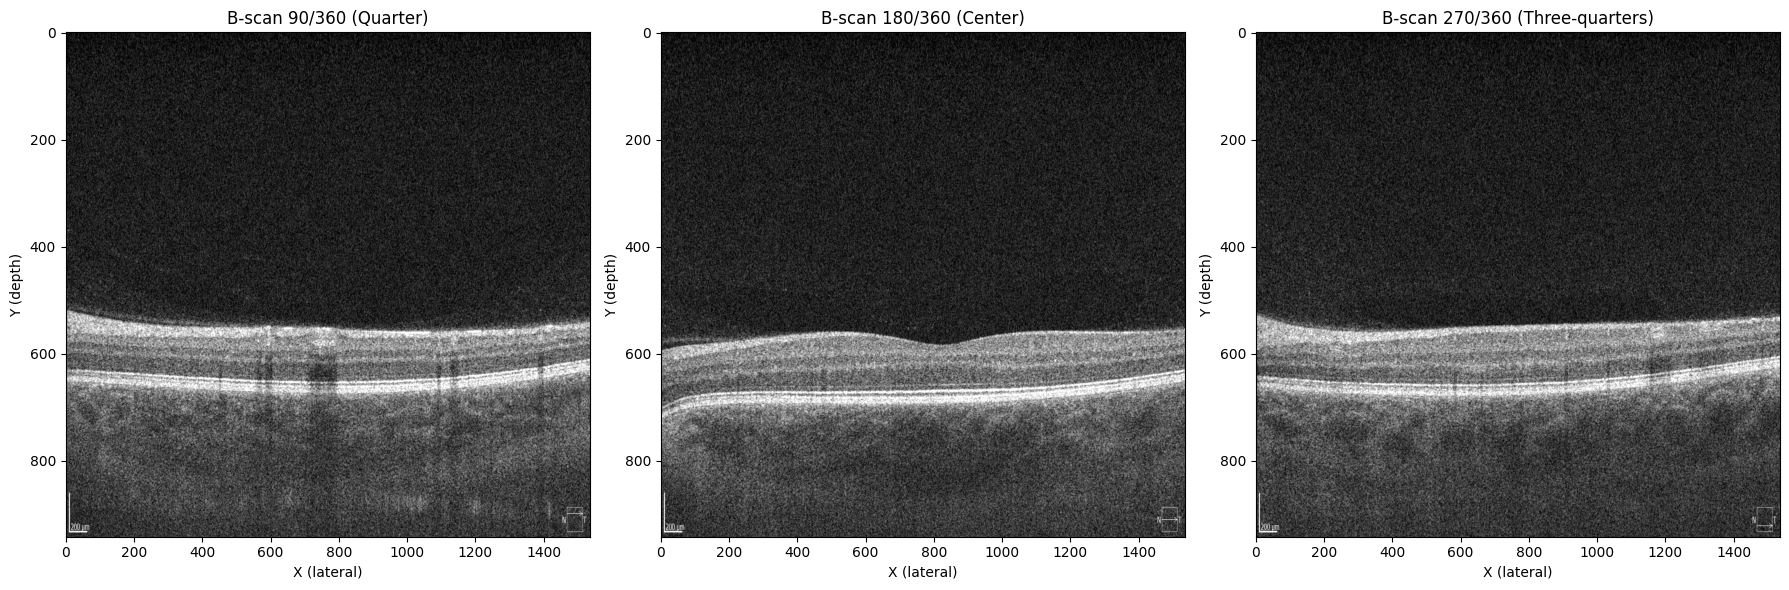


Observations:
- Top of image: vitreous (dark, low signal)
- Bright curved line: retinal surface (ILM - Inner Limiting Membrane)
- Layered structure: retinal tissue layers
- Bottom bright line: RPE (Retinal Pigment Epithelium)


In [3]:
# Show 3 B-scans from different depths
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

positions = [volume.shape[2] // 4, volume.shape[2] // 2, 3 * volume.shape[2] // 4]
titles = ['Quarter', 'Center', 'Three-quarters']

for ax, pos, title in zip(axes, positions, titles):
    bscan = volume[:, :, pos]
    ax.imshow(bscan, aspect='auto')
    ax.set_title(f'B-scan {pos}/{volume.shape[2]} ({title})', fontsize=12)
    ax.set_xlabel('X (lateral)')
    ax.set_ylabel('Y (depth)')
    ax.grid(False)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Top of image: vitreous (dark, low signal)")
print("- Bright curved line: retinal surface (ILM - Inner Limiting Membrane)")
print("- Layered structure: retinal tissue layers")
print("- Bottom bright line: RPE (Retinal Pigment Epithelium)")

---
## Method 1: Maximum Intensity Projection (MIP)

**Concept**: Take maximum intensity along depth axis.

**Pros**: Simple, fast, shows vessels well

**Cons**: Not a true surface, includes deep structures

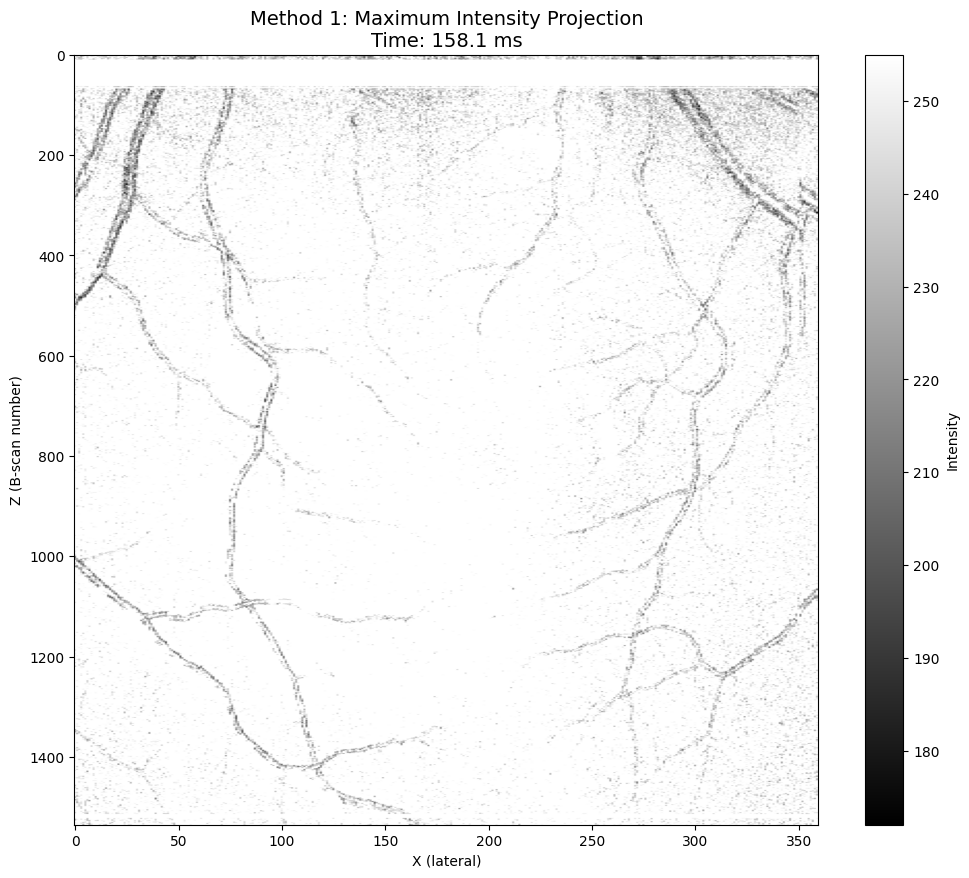

MIP shape: (1536, 360)
Processing time: 158.14 ms


In [4]:
def method_mip(volume):
    """Maximum Intensity Projection along depth axis."""
    start = time.time()
    enface = np.max(volume, axis=0)  # Max along Y (depth)
    elapsed = time.time() - start
    return enface, elapsed

enface_mip, time_mip = method_mip(volume)

plt.figure(figsize=(12, 10))
plt.imshow(enface_mip, aspect='auto')
plt.title(f'Method 1: Maximum Intensity Projection\nTime: {time_mip*1000:.1f} ms', fontsize=14)
plt.xlabel('X (lateral)')
plt.ylabel('Z (B-scan number)')
plt.colorbar(label='Intensity')
plt.show()

print(f"MIP shape: {enface_mip.shape}")
print(f"Processing time: {time_mip*1000:.2f} ms")

---
## Method 2: Surface Peak Detection

**Concept**: For each A-scan (column), find the first strong peak (retinal surface).

**Pros**: Detects actual surface position

**Cons**: May be affected by noise

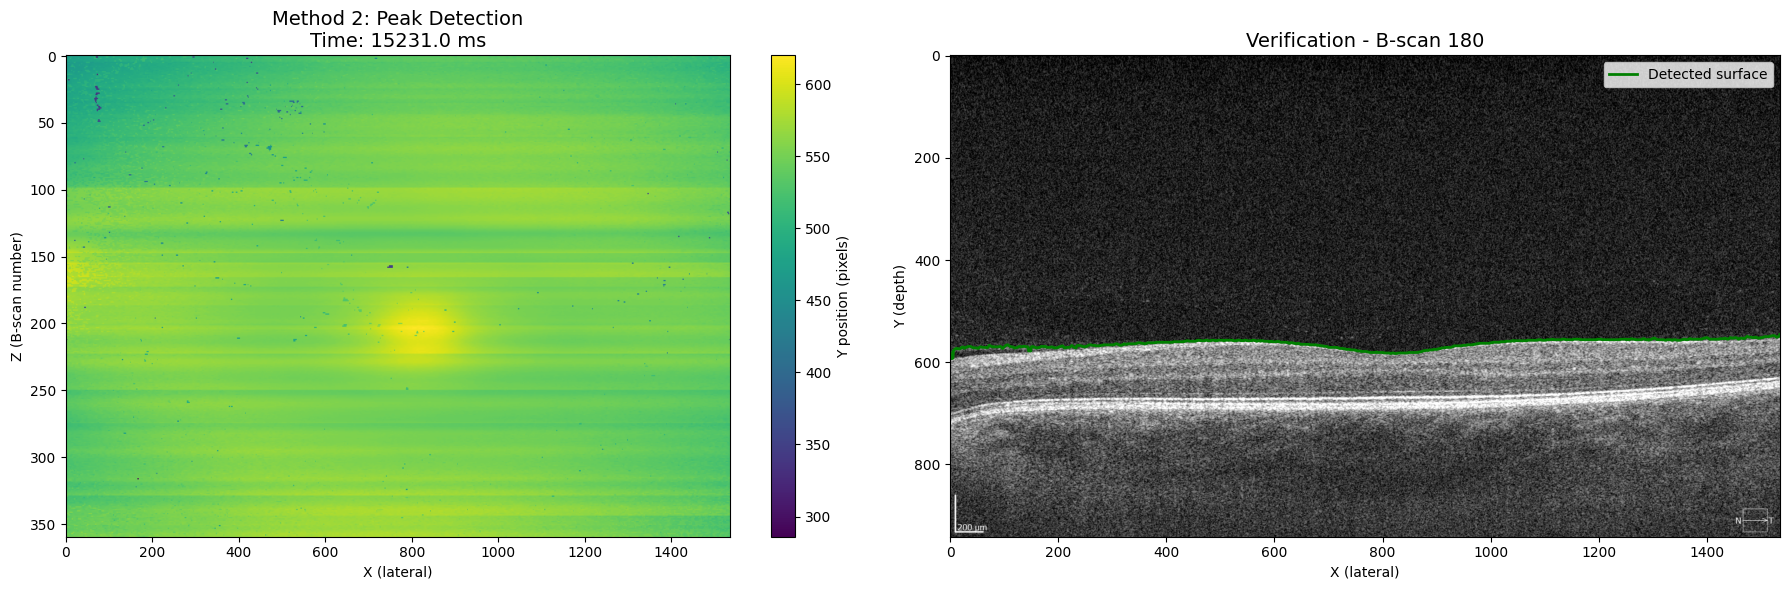


Surface height range: [286, 620] pixels
Processing time: 15230.97 ms

Note: Using simple first peak detection.
Mirror artifact filtering proved difficult - will rely on vessel registration robustness instead.


In [5]:
def detect_surface_peaks(volume, threshold_percentile=75, smooth_sigma=2):
    """
    Detect retinal surface by finding first peak in each A-scan.
    
    Args:
        volume: 3D OCT volume (H, W, D)
        threshold_percentile: Percentile for thresholding peaks
        smooth_sigma: Gaussian smoothing for noise reduction
    
    Returns:
        surface_heights: 2D array (W, D) with surface Y-position for each A-scan
    """
    start = time.time()
    
    H, W, D = volume.shape
    surface_heights = np.zeros((W, D), dtype=np.int32)
    
    # Calculate threshold from volume statistics
    threshold = np.percentile(volume, threshold_percentile)
    
    for z in range(D):
        bscan = volume[:, :, z]
        
        # Smooth to reduce noise
        if smooth_sigma > 0:
            bscan_smooth = ndimage.gaussian_filter(bscan, sigma=smooth_sigma)
        else:
            bscan_smooth = bscan
        
        for x in range(W):
            ascan = bscan_smooth[:, x]
            
            # Find first position above threshold (searching from top)
            peaks = np.where(ascan > threshold)[0]
            
            if len(peaks) > 0:
                surface_heights[x, z] = peaks[0]
            else:
                # No peak found, use middle as fallback
                surface_heights[x, z] = H // 2
    
    elapsed = time.time() - start
    return surface_heights, elapsed


# Use simple peak detection
surface_peaks, time_peaks = detect_surface_peaks(volume)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Show detected surface
im1 = axes[0].imshow(surface_peaks.T, aspect='auto', cmap='viridis')
axes[0].set_title(f'Method 2: Peak Detection\nTime: {time_peaks*1000:.1f} ms', fontsize=14)
axes[0].set_xlabel('X (lateral)')
axes[0].set_ylabel('Z (B-scan number)')
plt.colorbar(im1, ax=axes[0], label='Y position (pixels)')

# Verification on B-scan
mid_z = volume.shape[2] // 2
axes[1].imshow(volume[:, :, mid_z], aspect='auto')
axes[1].plot(range(volume.shape[1]), surface_peaks[:, mid_z], 'g-', linewidth=2, label='Detected surface')
axes[1].set_title(f'Verification - B-scan {mid_z}', fontsize=14)
axes[1].set_xlabel('X (lateral)')
axes[1].set_ylabel('Y (depth)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSurface height range: [{surface_peaks.min()}, {surface_peaks.max()}] pixels")
print(f"Processing time: {time_peaks*1000:.2f} ms")
print(f"\nNote: Using simple first peak detection.")
print(f"Mirror artifact filtering proved difficult - will rely on vessel registration robustness instead.")

---
## Summary and Export for Phase 2

**Conclusion**: We'll use two methods:
- **MIP (Method 1)**: For XY vessel registration - shows vessels very clearly
- **Peak Detection (Method 2)**: For surface height estimation

In [6]:
# Save results for Phase 2
output_dir = Path('../notebooks/data')
output_dir.mkdir(exist_ok=True)

# MIP for vessel-based XY registration
np.save(output_dir / 'enface_mip_volume0.npy', enface_mip)

# Peak surface for reference
np.save(output_dir / 'surface_peaks_volume0.npy', surface_peaks)

print(f"✓ Saved MIP en-face to {output_dir / 'enface_mip_volume0.npy'}")
print(f"✓ Saved peak surface to {output_dir / 'surface_peaks_volume0.npy'}")
print(f"\n📋 RESULTS:")
print(f"  - MIP shape: {enface_mip.shape}")
print(f"  - Surface shape: {surface_peaks.shape}")
print(f"\n✓ Ready for Phase 2: Vessel enhancement and registration!")

✓ Saved MIP en-face to ../notebooks/data/enface_mip_volume0.npy
✓ Saved peak surface to ../notebooks/data/surface_peaks_volume0.npy

📋 RESULTS:
  - MIP shape: (1536, 360)
  - Surface shape: (1536, 360)

✓ Ready for Phase 2: Vessel enhancement and registration!


2025-10-27 15:50:00,296 - INFO - Found 360 BMP files
2025-10-27 15:50:00,343 - INFO - Loading scan 1/360


Loading second volume: F001_IP_20250604_180102_Retina_3D_L_6mm_1536x360_2


2025-10-27 15:50:03,077 - INFO - Loading scan 51/360
2025-10-27 15:50:05,591 - INFO - Loading scan 101/360
2025-10-27 15:50:08,090 - INFO - Loading scan 151/360
2025-10-27 15:50:10,626 - INFO - Loading scan 201/360
2025-10-27 15:50:13,111 - INFO - Loading scan 251/360
2025-10-27 15:50:15,586 - INFO - Loading scan 301/360
2025-10-27 15:50:18,100 - INFO - Loading scan 351/360
2025-10-27 15:50:18,603 - INFO - Successfully loaded volume with shape (942, 1536, 360)



Volume 1 shape: (942, 1536, 360)
Value range: [0.0, 255.0]

Applying MIP...
  Time: 149.11 ms

Detecting surface peaks...
  Time: 18367.73 ms


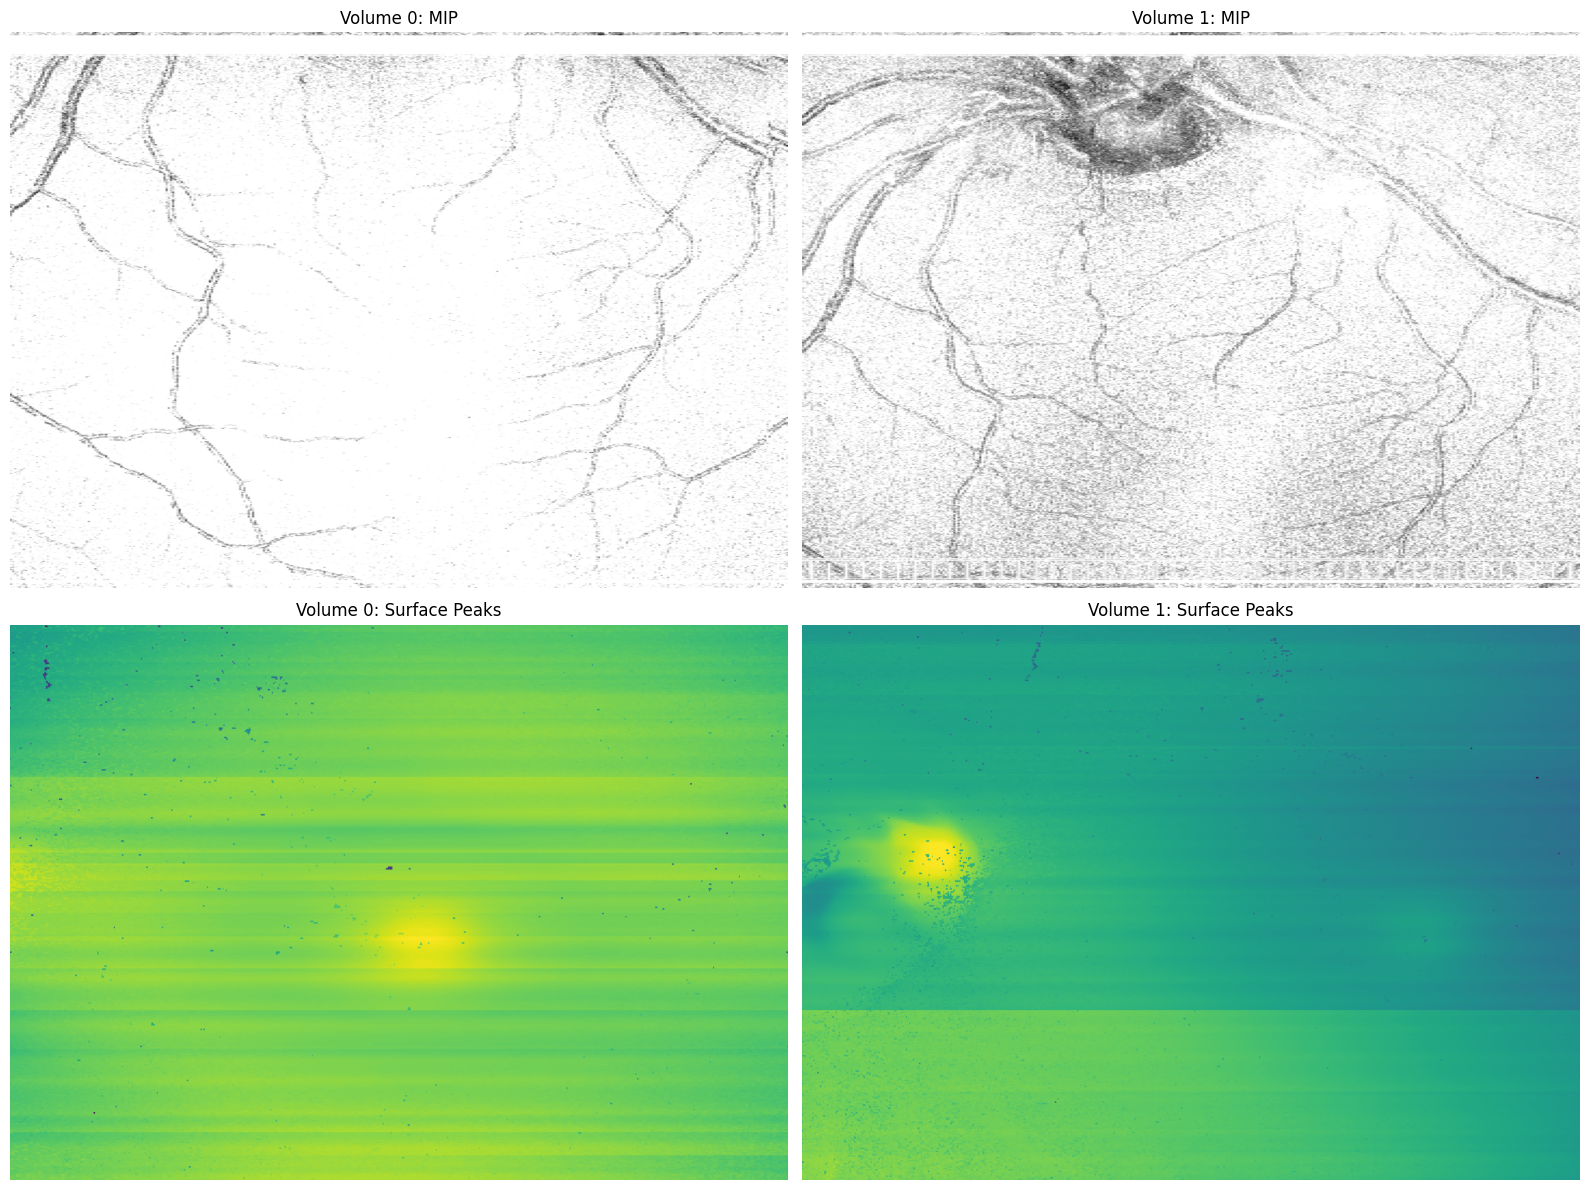


✓ Saved volume 1 MIP to ../notebooks/data/enface_mip_volume1.npy
✓ Saved volume 1 surface to ../notebooks/data/surface_peaks_volume1.npy

✓ Both volumes processed and ready for Phase 2!


In [7]:
# Load volume 1
print(f"Loading second volume: {volume_dirs[1].name}")

volume1 = loader.load_volume_from_directory(str(volume_dirs[1]))

print(f"\nVolume 1 shape: {volume1.shape}")
print(f"Value range: [{volume1.min()}, {volume1.max()}]")

# Apply same methods
print("\nApplying MIP...")
enface_mip_v1, time_mip_v1 = method_mip(volume1)
print(f"  Time: {time_mip_v1*1000:.2f} ms")

print("\nDetecting surface peaks...")
surface_peaks_v1, time_peaks_v1 = detect_surface_peaks(volume1)
print(f"  Time: {time_peaks_v1*1000:.2f} ms")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].imshow(enface_mip, aspect='auto')
axes[0, 0].set_title('Volume 0: MIP')
axes[0, 0].axis('off')

axes[0, 1].imshow(enface_mip_v1, aspect='auto')
axes[0, 1].set_title('Volume 1: MIP')
axes[0, 1].axis('off')

axes[1, 0].imshow(surface_peaks.T, aspect='auto', cmap='viridis')
axes[1, 0].set_title('Volume 0: Surface Peaks')
axes[1, 0].axis('off')

axes[1, 1].imshow(surface_peaks_v1.T, aspect='auto', cmap='viridis')
axes[1, 1].set_title('Volume 1: Surface Peaks')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Save volume 1 results
np.save(output_dir / 'enface_mip_volume1.npy', enface_mip_v1)
np.save(output_dir / 'surface_peaks_volume1.npy', surface_peaks_v1)

print(f"\n✓ Saved volume 1 MIP to {output_dir / 'enface_mip_volume1.npy'}")
print(f"✓ Saved volume 1 surface to {output_dir / 'surface_peaks_volume1.npy'}")
print(f"\n✓ Both volumes processed and ready for Phase 2!")

---
## Process Volume 1

Now process the second volume with the same pipeline for registration.